# Adaptive PDE discretizations on Cartesian grids
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Riemannian metrics

In this notebook, we solve Riemannian eikonal equations on the CPU and the GPU, and check that they produce consistent results.

**GPU performance** GPUs are massively parallel machines, which efficiently exploit cache locality. Hence they are at their advantage with :
* Large problem instances, which are embarassingly parallel
* Moderate anisotropy, so that the numerical scheme stncils are not too wide

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensions](#1.-Two-dimensions)
    * [1.1 Isotropic metric](#1.1-Isotropic-metric)
    * [1.2 Smooth anisotropic metric](#1.2-Smooth-anisotropic-metric)
  * [2. Three dimensions](#2.-Three-dimensions)
    * [2.1 Smooth anisotropic metric](#2.1-Smooth-anisotropic-metric)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Riemann_GPU','Repro'))

In [2]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError('Cupy module required')
from agd import Eikonal
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

from agd.ExportedCode.Notebooks_Repro.Isotropic_GPU import RunCompare
Eikonal.dictIn.default_mode = 'gpu'

DeliberateNotebookError: Cupy module required

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,cugen,RunGPU,RunSmart,Metrics
    Eikonal,ad,cugen,Metrics = rreload([Eikonal,ad,cugen,Metrics],"../..")    
    Eikonal.dictIn.default_mode = 'gpu'

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)

### 0.1 Additional configuration

In [6]:
large_instances = False # True favors the GPU code (CPU times may become a big long.)
strong_anisotropy = True # True favors the CPU code 
anisotropy_bound = 10. if strong_anisotropy else 4. # Ratio between the fastest and the smallest velocity at any given point

In [7]:
def surface_metric(x,z,mu):
    ndim,shape = x.ndim-1,x.shape[1:]
    x_ad = ad.Dense.identity(constant=x,shape_free=(ndim,))
    tensors = lp.outer_self( z(x_ad).gradient() ) + mu**-2 * fd.as_field(cp.eye(ndim),shape)
    return Metrics.Riemann(tensors)

## 1. Two dimensions

### 1.1 Isotropic metric

In [8]:
n=4000 if large_instances else 1000
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'metric':Metrics.Riemann.from_cast(Metrics.Isotropic(cp.array(1.),vdim=2)),
    'seed':[0.5,0.5],
    'exportValues':1,
#    'bound_active_blocks':True,
    'traits':{
        'niter_i':24,'shape_i':(12,12), # Best
    }
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

In [9]:
_,cpuOut = RunCompare(hfmIn,check=1e-5)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.06245279312133789 seconds, and 115 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.403 s.
Solver time (s). GPU : 0.06245279312133789, CPU : 0.765. Device acceleration : 12.249251983233187
Max |gpuValues-cpuValues| :  2.91457399725914e-06


In [10]:
n=200; hfmInS = hfmIn.copy() # Define a small instance for bit-consistency validation
hfmInS.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X = hfmInS.Grid()
cost = np.prod(np.sin(2*np.pi*X),axis=0)+1.1
hfmInS.update({
    'metric': Metrics.Riemann.from_cast(Metrics.Isotropic(cost,vdim=2)), # Isotropic but non-constant metric
    'verbosity':0,
})

In [11]:
RunCompare(hfmInS,variants='basic')

Solver time (s). GPU : 0.015653610229492188, CPU : 0.028. Device acceleration : 1.7887247471670527
Max |gpuValues-cpuValues| :  1.3399500079502857e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.015623807907104492, CPU : 0.027. Device acceleration : 1.7281318459965513
Max |gpuValues-cpuValues| :  4.0380158106145814e-08

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.0067501068115234375, CPU : 0.027. Device acceleration : 3.9999367052839783
Max |gpuValues-cpuValues| :  1.2327583520654883e-06

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.02435159683227539, CPU : 0.027. Device acceleration : 1.1087568583680902
Max |gpuValues-cpuValues| :  5.4531370752286534e-08


In [12]:
RunCompare(hfmInS,variants='ext',check=0.004)

Solver time (s). GPU : 0.0169827938079834, CPU : 0.028. Device acceleration : 1.6487275483988713
Max |gpuValues-cpuValues| :  1.3399500079502857e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.014957427978515625, CPU : 0.03. Device acceleration : 2.005692425401683
Max |gpuValues-cpuValues| :  4.0380158106145814e-08

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.01495981216430664, CPU : 0.034. Device acceleration : 2.2727558091352438
Max |gpuValues-cpuValues| :  1.2327583520654883e-06

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.0020475387573242188, CPU : 0.028. Device acceleration : 13.67495482068002
Max |gpuValues-cpuValues| :  5.4531370752286534e-08

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.01496124267578125, CPU : 0.028999999999999998. Device acceleration : 1.938341662417134
Max |gpuValues-cpuValues| :  0.0009697226141481136

 --- Variant {'fact

### 1.2 Smooth anisotropic metric

In [13]:
n=3000 if large_instances else 1000
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'seed':[0.,0.],
    'exportValues':1,
#    'traits':{'niter_i':8,'shape_i':(8,8),},'fim_front_width':4, 
})
hfmIn.SetRect([[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)

In [14]:
def height(x): 
    r = fd.as_field(lp.rotation(cp.asarray(np.pi)/3),x.shape[1:])
    y = 2*lp.dot_AV(r,x)
    return np.sin(y[0])*np.sin(y[1]) 

In [15]:
hfmIn['metric'] = surface_metric(hfmIn.Grid(),height,mu=anisotropy_bound)

In [16]:
gpuOut,cpuOut = RunCompare(hfmIn,check=False)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.16755127906799316 seconds, and 374 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.076 s.
Solver time (s). GPU : 0.16755127906799316, CPU : 1.7630000000000001. Device acceleration : 10.522151843941256
Max |gpuValues-cpuValues| :  2.1309004127223474e-05


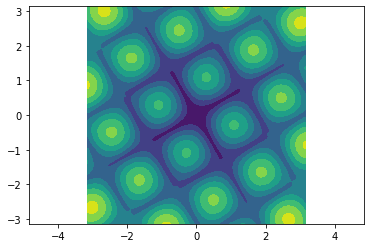

In [17]:
plt.contourf(*hfmIn.Grid(),gpuOut['values']) 
plt.axis('equal');

In [18]:
n=200; hfmInS = hfmIn.copy() # Define a small instance for bit-consistency validation
hfmInS.SetRect([[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)
hfmInS.update({
    'metric' : surface_metric(hfmInS.Grid(),height,mu=anisotropy_bound), 
    'verbosity':0,
})

In [19]:
RunCompare(hfmInS,variants='basic',check=0.0008)

Solver time (s). GPU : 0.029919147491455078, CPU : 0.059. Device acceleration : 1.9719813212208144
Max |gpuValues-cpuValues| :  1.3411698919219006e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.028894901275634766, CPU : 0.06. Device acceleration : 2.076490915391851
Max |gpuValues-cpuValues| :  2.941561464686604e-07

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.024925708770751953, CPU : 0.06. Device acceleration : 2.407153214852792
Max |gpuValues-cpuValues| :  0.0005127510391062778

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.028939008712768555, CPU : 0.059. Device acceleration : 2.0387705945839065
Max |gpuValues-cpuValues| :  0.0005127510391062778


Source factorization is implemented differently, and not applied on the same domain (square vs disk), between the CPU and GPU implementations. Hence the results differ somewhat more : there is no bit-consistency.

<!---
Due to the different switching criteria of the second order scheme, we do not have bit consistency in that case. The results are nevertheless quite close. Note also that we do not deactivate the `decreasing` trait here, contrary to the isotropic case, because the scheme often does not converge without it.

**Bottom line.** Second order accuracy for anisotropic metrics on the GPU is very experimental, and not much reliable, at this stage. Further investigation is needed on the matter.
--->

In [20]:
RunCompare(hfmInS,variants='ext',check=0.008)

Solver time (s). GPU : 0.02690577507019043, CPU : 0.057999999999999996. Device acceleration : 2.155671035258881
Max |gpuValues-cpuValues| :  1.3411698919219006e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.013707399368286133, CPU : 0.062. Device acceleration : 4.523104517071643
Max |gpuValues-cpuValues| :  2.941561464686604e-07

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.026917695999145508, CPU : 0.056. Device acceleration : 2.0804157979114444
Max |gpuValues-cpuValues| :  0.0005127510391062778

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.02691173553466797, CPU : 0.057. Device acceleration : 2.118035082745668
Max |gpuValues-cpuValues| :  0.0005127510391062778

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.0312347412109375, CPU : 0.056. Device acceleration : 1.792875427454812
Max |gpuValues-cpuValues| :  0.005569850065682891

 --- Variant {'factoring

Second order accuracy for anisotropic metrics on the GPU is only experimental, and not reliable, at this stage. Further investigation is needed on the matter.
Even obtaining the scheme convergence is hard, and requires setting some other parameters carefully and conservatively.

<!---
hfmInS.update({
    'order2_threshold':0.03,
    'verbosity':1,
    'traits':{'decreasing_macro':0,'order2_threshold_weighted_macro':1},
    'metric' : surface_metric(hfmInS.Grid(),height),
    'multiprecision':False,
    'tol':1e-6
})
--->

In [21]:
hfmInS.update({
    'tol':1e-6, # Tolerance for the convergence of the fixed point solver
    'order2_threshold':0.03, # Use first order scheme if second order difference is too large
    'traits':{'decreasing_macro':0}, # Do not enforce monotonicity
})

In [22]:
RunCompare(hfmInS,variants='ext2',check=0.3)

Solver time (s). GPU : 0.03123784065246582, CPU : 0.056. Device acceleration : 1.7926975370360476
Max |gpuValues-cpuValues| :  1.2219606023711194e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.026927947998046875, CPU : 0.059. Device acceleration : 2.191032157529395
Max |gpuValues-cpuValues| :  1.0598938896544396e-06

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.0249330997467041, CPU : 0.059. Device acceleration : 2.3663323292884666
Max |gpuValues-cpuValues| :  0.0005127510391062778

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.023737192153930664, CPU : 0.057999999999999996. Device acceleration : 2.4434229467361717
Max |gpuValues-cpuValues| :  0.0005127510391062778

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.031237125396728516, CPU : 0.055999999999999994. Device acceleration : 1.7927385855378648
Max |gpuValues-cpuValues| :  0.005569850065682891

 ---

In [23]:
# TODO : discontinuous metric

## 2. Three dimensions

### 2.1 Smooth anisotropic metric

We generalize the two dimensional test case, although it does not much make geometrical sense anymore: we are computing geodesics in a three dimensional volume viewed as an hypersurface embedded in four dimensional Euclidean space.

In [24]:
n=200 if large_instances else 100
hfmIn = Eikonal.dictIn({
    'model':'Riemann3',
    'seed':[0.,0.,0.],
    'exportValues':1,
#    'traits':{'niter_i':4},'fim_front_width':6,
})
hfmIn.SetRect([[-np.pi,np.pi],[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)

In [25]:
def height3(x): 
    r = fd.as_field(lp.rotation(cp.asarray(np.pi)/3,cp.asarray((1.,2,3))),x.shape[1:])
    y = 2*lp.dot_AV(r,x)
#    y=x
    return np.sin(y[0])*np.sin(y[1])*np.sin(y[2])

In [26]:
hfmIn['metric'] = surface_metric(hfmIn.Grid(),height3,mu=anisotropy_bound)

In [27]:
gpuOut,cpuOut = RunCompare(hfmIn,check=1e-4)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.10934591293334961 seconds, and 93 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 3.985 s.
Solver time (s). GPU : 0.10934591293334961, CPU : 6.093999999999999. Device acceleration : 55.731392573534215
Max |gpuValues-cpuValues| :  2.340651752863465e-06


In [28]:
n=50; hfmInS = hfmIn.copy() # Define a small instance for bit-consistency validation
hfmInS.SetRect([[-np.pi,np.pi],[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)
hfmInS.update({
    'metric' : surface_metric(hfmInS.Grid(),height3,mu=anisotropy_bound), 
    'verbosity':0,
})

In [29]:
RunCompare(hfmInS,variants='ext',check=0.02)

Solver time (s). GPU : 0.028921842575073242, CPU : 0.5760000000000001. Device acceleration : 19.915743559728625
Max |gpuValues-cpuValues| :  2.6433073914700067e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.03124237060546875, CPU : 0.5740000000000001. Device acceleration : 18.372485470085472
Max |gpuValues-cpuValues| :  2.6433073914700067e-06

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.015651702880859375, CPU : 0.585. Device acceleration : 37.37612478674141
Max |gpuValues-cpuValues| :  0.00485777620687023

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.031202077865600586, CPU : 0.6779999999999999. Device acceleration : 21.729322095804264
Max |gpuValues-cpuValues| :  0.004857772481579932

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.03288555145263672, CPU : 0.612. Device acceleration : 18.609996578023953
Max |gpuValues-cpuValues| :  0.01243766163005367

Again, the GPU implementation of the second order scheme is purely experimental at this stage, and should not be relied upon.

<!---
Due to the different switching criteria of the second order scheme, we do not have bit consistency in that case. The results are nevertheless quite close.
--->

In [30]:
RunCompare(hfmInS,variants='ext2',check=0.1)

Solver time (s). GPU : 0.028961181640625, CPU : 0.575. Device acceleration : 19.854162276080082
Max |gpuValues-cpuValues| :  2.6433073914700067e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.031241893768310547, CPU : 0.5880000000000001. Device acceleration : 18.820882125795574
Max |gpuValues-cpuValues| :  2.6433073914700067e-06

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.031227827072143555, CPU : 0.5780000000000001. Device acceleration : 18.509132853358174
Max |gpuValues-cpuValues| :  0.00485777620687023

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.03123617172241211, CPU : 0.677. Device acceleration : 21.673590669699422
Max |gpuValues-cpuValues| :  0.004857772481579932

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.03091716766357422, CPU : 0.651. Device acceleration : 21.056262562077794
Max |gpuValues-cpuValues| :  0.012437661630053672

 --- Variant